In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matrix

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data

In [7]:
datapath = "/home/asd/data/gsm/"
savepath = "/home/asd/saved/"

factors = {}
for alg in matrix.get_models(50, 10).keys():
    factors[alg] = {}
    for t in matrix.TIME_POINTS:
        W = np.load(savepath + "embryo" + str(t) + "_" + alg + "_W.npy")
        H = np.load(savepath + "embryo" + str(t) + "_" + alg + "_H.npy")
        factors[alg][t] = matrix.clean_factors(W, H)

### Plot factors

0.9329751043754306


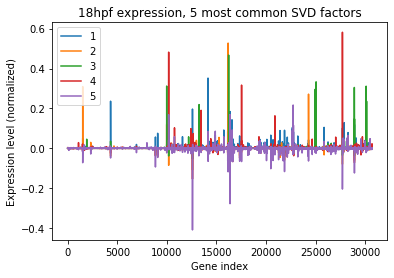

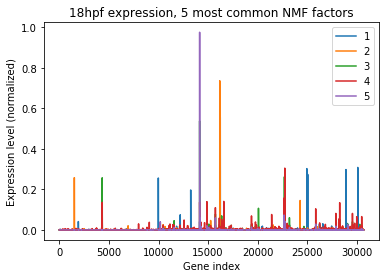

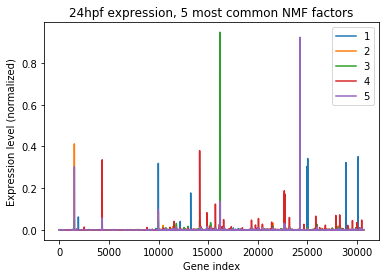

In [46]:
W24, H24 = factors['nmf'][24]
W18, H18 = factors['nmf'][18]
W18p, H18p = factors['svd'][18]


for (title, data) in [
    ("18hpf expression, 5 most common SVD factors", H18p),
    ("18hpf expression, 5 most common NMF factors", H18),
    ("24hpf expression, 5 most common NMF factors", H24)
]:
    plt.figure()
    plt.plot(data[0:5, :].T)
    
    plt.legend(range(1, 6))
    plt.title(title)
    plt.xlabel("Gene index")
    plt.ylabel("Expression level (normalized)")


print(matrix.score_factor_pairing(H18, H24))

In [10]:
W8, H8, loss8 = fit_nmf(hour8, 50)
print("Loss:", loss8)

Loss: 0.2654755924721412


In [11]:
W10, H10, loss10 = fit_nmf(hour10, 50)
print("Loss:", loss10)

Loss: 0.23548096087104697


### Now have these models vary over time

We have data that varies over time, but comes from the same underlying "process." Let's model this as a series of matrix factorizations. Our objective function will be

$$ 
J(W, H) 
= 
\sum_{t=1}^T  \| W^{(t)} H^{(t)} - X^{(t)} \|_F^2 
+ \sum_{t=2}^T  \| H^{(t)} - H^{(t-1)} \|_F^2 
+ R(W, H)
$$

where $R(W,H)$ is an additional regularizer, e.g. nonnegativity, sparsity, etc.

Some questions:
- What if we formulate this as a Bayesian network, where the factors $H$ form a Markov process, but ottherwise everything is the same.
- Is there a natural Bayesian network interpretation of these update rules, which can then be generalized to larger networks?